# Environment simulation for Contextual Bandits

> In this notebook, we'll evaluate the performance of Linear Contextual Bandits in an MF-based environment. This environment will accept contextual (per-arm) features about users and items

* Environment will compute a low-rank matrix factorization (using SVD) of the `<user, item>` data matrix
* Use the movielens dataset to formulate an approximate item rating for each user (collaborative filtering)
* Train a linear RL algorithm, the [LinUCB](https://www.tensorflow.org/agents/tutorials/intro_bandit) agent, which incorporates exploration via boosting the estimates by an amount that corresponds to the variance of those estimates

**What are per-arm features?**
* In some bandits use cases, each arm has its own features. For example, in movie recommendation problems, the user features play the role of the context and the movies play the role of the arms (aka actions) 
* Each movie has its own features, such as `text description`, `metadata`, `trailer content` features and so on

These problems are often referred to as `arm features problems`

In [1]:
! python3 -c "import google.cloud.aiplatform; print('aiplatform SDK version: {}'.format(google.cloud.aiplatform.__version__))"

aiplatform SDK version: 1.33.1


## Load env config

* use the prefix from `00-env-setup`

In [2]:
# PREFIX = 'mabv1'
VERSION        = "v2"                       # TODO
PREFIX         = f'rec-bandits-{VERSION}'   # TODO

print(f"PREFIX: {PREFIX}")

PREFIX: rec-bandits-v2


**run the next cell to populate env vars**

In [3]:
# staging GCS
GCP_PROJECTS             = !gcloud config get-value project
PROJECT_ID               = GCP_PROJECTS[0]

# GCS bucket and paths
BUCKET_NAME              = f'{PREFIX}-{PROJECT_ID}-bucket'
BUCKET_URI               = f'gs://{BUCKET_NAME}'

config = !gsutil cat {BUCKET_URI}/config/notebook_env.py
print(config.n)
exec(config.n)


PROJECT_ID               = "hybrid-vertex"
PROJECT_NUM              = "934903580331"
LOCATION                 = "us-central1"

REGION                   = "us-central1"
BQ_LOCATION              = "US"
VPC_NETWORK_NAME         = "ucaip-haystack-vpc-network"

VERTEX_SA                = "934903580331-compute@developer.gserviceaccount.com"

PREFIX                   = "rec-bandits-v2"
VERSION                  = "v2"

BUCKET_NAME              = "rec-bandits-v2-hybrid-vertex-bucket"
BUCKET_URI               = "gs://rec-bandits-v2-hybrid-vertex-bucket"
DATA_GCS_PREFIX          = "data"
DATA_PATH                = "gs://rec-bandits-v2-hybrid-vertex-bucket/data"
VOCAB_SUBDIR             = "vocabs"
VOCAB_FILENAME           = "vocab_dict.pkl"
DATA_PATH_KFP_DEMO       = "gs://rec-bandits-v2-hybrid-vertex-bucket/data/kfp_demo_data/u.data"

VPC_NETWORK_FULL         = "projects/934903580331/global/networks/ucaip-haystack-vpc-network"

BIGQUERY_DATASET_NAME    = "mvlens_rec_bandits_v2"
BIGQUERY_TABLE_NA

In [4]:
# ! gsutil ls $BUCKET_URI

## imports

In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [6]:
import functools
import json
from collections import defaultdict
from typing import Callable, Dict, List, Optional, TypeVar
from datetime import datetime
import time
from pprint import pprint

import logging
logging.disable(logging.WARNING)

import matplotlib.pyplot as plt
import numpy as np

# google cloud
from google.cloud import aiplatform, storage

# tensorflow
import tensorflow as tf
from tf_agents.agents import TFAgent
from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.bandits.agents.examples.v2 import trainer
from tf_agents.bandits.environments import (environment_utilities,
                                            movielens_py_environment,
                                            movielens_per_arm_py_environment)
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import TFEnvironment, tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.metrics.tf_metric import TFStepMetric
from tf_agents.policies import policy_saver

# GPU
from numba import cuda 
import gc

# tf exceptions and vars
if tf.__version__[0] != "2":
    raise Exception("The trainer only runs with TensorFlow version 2.")

T = TypeVar("T")

In [7]:
import sys
sys.path.append("..")

# my project
from src.per_arm_rl import train_utils
from src.per_arm_rl import data_utils
from src.per_arm_rl import trainer_baseline

from src.per_arm_rl import data_config
# from src.per_arm_rl import data_config_1m as data_config

### detect GPUs & reset devices

In [8]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [9]:
device = cuda.get_current_device()
device.reset()
gc.collect()

14

### Initialize Google Cloud SDK Clients

In [10]:
# cloud storage client
storage_client = storage.Client(project=PROJECT_ID)

# Vertex client
aiplatform.init(project=PROJECT_ID, location=LOCATION)

# Data prep

In [11]:
DATA_TAG = "movielens-100k" # movielens-100k | movielens-1m

print(f"DATA_TAG: {DATA_TAG}")

DATA_TAG: movielens-100k


### Load data config

In [12]:
# print(f"USER_AGE_LOOKUP: {data_config.USER_AGE_LOOKUP}")
# print(f"USER_AGE_DIM: {data_config.USER_AGE_DIM}")

# print(f"USER_OCC_LOOKUP: {data_config.USER_OCC_LOOKUP}")
# print(f"USER_OCC_DIM: {data_config.USER_OCC_DIM}")

# print(f"MOVIE_GEN_LOOKUP: {data_config.MOVIE_GEN_LOOKUP}")
# print(f"MOVIE_GEN_DIM: {data_config.MOVIE_GEN_DIM}")

# print(f"MOVIELENS_NUM_MOVIES: {data_config.MOVIELENS_NUM_MOVIES}")
# print(f"MOVIELENS_NUM_USERS: {data_config.MOVIELENS_NUM_USERS}")

In [13]:
# type(data_config.USER_OCC_LOOKUP)

### Read TF Records

In [14]:
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.AUTO

In [15]:
SPLIT = "train" # "train" | "val" | "all"

train_files = []
for blob in storage_client.list_blobs(
    f"{BUCKET_NAME}", 
    prefix=f'{DATA_GCS_PREFIX}/{DATA_TAG}/{SPLIT}/', 
    # delimiter='/'
):
    if '.tfrecord' in blob.name:
        train_files.append(blob.public_url.replace("https://storage.googleapis.com/", "gs://"))
        
train_files

['gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens-100k/train/ml-100k-ratings-train-01-of-05.tfrecord',
 'gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens-100k/train/ml-100k-ratings-train-02-of-05.tfrecord',
 'gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens-100k/train/ml-100k-ratings-train-03-of-05.tfrecord',
 'gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens-100k/train/ml-100k-ratings-train-04-of-05.tfrecord']

In [16]:
train_dataset = tf.data.TFRecordDataset(train_files)
train_dataset = train_dataset.map(data_utils.parse_tfrecord)

for x in train_dataset.batch(1).take(2):
    pprint(x)

{'bucketized_user_age': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([45.], dtype=float32)>,
 'movie_genres': <tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[7]])>,
 'movie_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'357'], dtype=object)>,
 'timestamp': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([879024327])>,
 'user_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'138'], dtype=object)>,
 'user_occupation_text': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'doctor'], dtype=object)>,
 'user_rating': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.], dtype=float32)>}
{'bucketized_user_age': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([25.], dtype=float32)>,
 'movie_genres': <tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[4]])>,
 'movie_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'709'], dtype=object)>,
 'timestamp': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([875654590])>,
 'user_id': <tf.Tensor: shape=(1

# Define RL modules

In [17]:
# !pwd

# Train RL modules

## set hyperparameters

In [18]:
# Set hyperparameters.
BATCH_SIZE       = 128      # Training and prediction batch size.
# TRAINING_LOOPS   = 300     # Number of training iterations.
# STEPS_PER_LOOP   = 2      # Number of driver steps per training iteration.

# Set MovieLens simulation environment parameters.
RANK_K           = 20     # Rank for matrix factorization in the MovieLens environment; also the observation dimension.
NUM_ACTIONS      = 10     # Number of actions (movie items) to choose from.
PER_ARM          = True   # Use the non-per-arm version of the MovieLens environment.

# Set agent parameters.
TIKHONOV_WEIGHT  = 0.001   # LinUCB Tikhonov regularization weight.
AGENT_ALPHA      = 10.0    # LinUCB exploration parameter that multiplies the confidence intervals.

print(f"BATCH_SIZE       : {BATCH_SIZE}")
# print(f"TRAINING_LOOPS   : {TRAINING_LOOPS}")
# print(f"STEPS_PER_LOOP   : {STEPS_PER_LOOP}")
print(f"RANK_K           : {RANK_K}")
print(f"NUM_ACTIONS      : {NUM_ACTIONS}")
print(f"PER_ARM          : {PER_ARM}")
print(f"TIKHONOV_WEIGHT  : {TIKHONOV_WEIGHT}")
print(f"AGENT_ALPHA      : {AGENT_ALPHA}")

BATCH_SIZE       : 128
RANK_K           : 20
NUM_ACTIONS      : 10
PER_ARM          : True
TIKHONOV_WEIGHT  : 0.001
AGENT_ALPHA      : 10.0


## Define RL environment

One can define a bandit environment by subclassing `BanditTFEnvironment`, or, similarly to RL environments, one can define a `BanditPyEnvironment` and wrap it with `TFPyEnvironment`

> See `src.per_arm_rl.my_per_arm_py_env.py` for an example custom environment which implements a per-arm version of the MovieLens environment

In [19]:
from src.per_arm_rl import my_per_arm_py_env as my_per_arm_py_env

In [20]:
env = my_per_arm_py_env.MyMovieLensPerArmPyEnvironment(
    project_number = PROJECT_NUM
    , data_path = DATA_PATH
    , bucket_name = BUCKET_NAME
    , data_gcs_prefix = f"{DATA_GCS_PREFIX}/{DATA_TAG}/{SPLIT}"
    , user_age_lookup_dict = data_config.USER_AGE_LOOKUP
    , user_occ_lookup_dict = data_config.USER_OCC_LOOKUP
    , movie_gen_lookup_dict = data_config.MOVIE_GEN_LOOKUP
    , num_users = data_config.MOVIELENS_NUM_USERS
    , num_movies = data_config.MOVIELENS_NUM_MOVIES
    , rank_k = RANK_K
    , batch_size = BATCH_SIZE
    , num_actions = NUM_ACTIONS
)

environment = tf_py_environment.TFPyEnvironment(env)

### inspect environment

In [21]:
# env.movie_gen_lookup_dict

In [22]:
env.dataset

<_MapDataset element_spec={'bucketized_user_age': TensorSpec(shape=(), dtype=tf.float32, name=None), 'movie_genres': TensorSpec(shape=(1,), dtype=tf.int64, name=None), 'movie_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'timestamp': TensorSpec(shape=(), dtype=tf.int64, name=None), 'user_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'user_occupation_text': TensorSpec(shape=(), dtype=tf.string, name=None), 'user_rating': TensorSpec(shape=(), dtype=tf.float32, name=None)}>

In [23]:
env._user_occ_int

array([14.0001,  7.0001, 10.0001, ..., 10.0001, 17.0001, 16.0001])

In [24]:
environment.observation_spec()

{'global': TensorSpec(shape=(22,), dtype=tf.float32, name=None),
 'per_arm': TensorSpec(shape=(10, 21), dtype=tf.float32, name=None)}

In [25]:
environment.time_step_spec()

TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': {'global': TensorSpec(shape=(22,), dtype=tf.float32, name=None),
                 'per_arm': TensorSpec(shape=(10, 21), dtype=tf.float32, name=None)},
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [26]:
environment.action_spec()

BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(9, dtype=int32))

In [27]:
environment.batch_size

128

## Define Bandit Agent

In [28]:
agent = lin_ucb_agent.LinearUCBAgent(
    time_step_spec = environment.time_step_spec()
    , action_spec = environment.action_spec()
    , tikhonov_weight = TIKHONOV_WEIGHT
    , alpha = AGENT_ALPHA
    , dtype = tf.float32
    , accepts_per_arm_features = PER_ARM
    , summarize_grads_and_vars = True
    , enable_summaries = True
)

agent.initialize()

print("TimeStep Spec (for each batch):\n", agent.time_step_spec, "\n")
print("Action Spec (for each batch)  :\n", agent.action_spec, "\n")
print("Reward Spec (for each batch)  :\n", environment.reward_spec(), "\n")

TimeStep Spec (for each batch):
 TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': DictWrapper({'global': TensorSpec(shape=(22,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(10, 21), dtype=tf.float32, name=None)}),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')}) 

Action Spec (for each batch)  :
 BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(9, dtype=int32)) 

Reward Spec (for each batch)  :
 TensorSpec(shape=(), dtype=tf.float32, name='reward') 



In [29]:
global_step = tf.compat.v1.train.get_or_create_global_step()

# saver = policy_saver.PolicySaver(
#     agent.policy, 
#     train_step=global_step
# )

#### The flow of training data

First, let us have a look at the data specification in the agent. The `training_data_spec` attribute of the agent specifies what elements and structure the training data should have.

In [30]:
print('training data spec: ', agent.training_data_spec)

training data spec:  Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(9, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': DictWrapper({'global': TensorSpec(shape=(22,), dtype=tf.float32, name=None)}),
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=(), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=TensorSpec(shape=(21,), dtype=tf.float32, name=None)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})


If we have a closer look to the `observation` part of the spec, we see that it does not contain per-arm features!

In [31]:
print('observation spec in training: ', agent.training_data_spec.observation)

observation spec in training:  {'global': TensorSpec(shape=(22,), dtype=tf.float32, name=None)}


What happened to the per-arm features? To answer this question, first we note that when the LinUCB agent trains, it does not need the per-arm features of all arms, it only needs those of the **chosen arm**. Hence, it makes sense to drop the tensor of shape `[BATCH_SIZE, NUM_ACTIONS, PER_ARM_DIM]`, as it is very wasteful, especially if the number of actions is large.

But still, the per-arm features of the chosen arm must be somewhere! To this end, we make sure that the LinUCB policy stores the features of the chosen arm within the `policy_info` field of the training data:

In [32]:
print('chosen arm features: ', agent.training_data_spec.policy_info.chosen_arm_features)

chosen arm features:  TensorSpec(shape=(21,), dtype=tf.float32, name=None)


## Define RL metrics

Bandits' most important metric is **regret**, calculated as the difference between the reward collected by the agent and the expected reward of an oracle policy that has access to the reward functions of the environment. The [RegretMetric](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/metrics/tf_metrics.py) thus needs a `baseline_reward_fn` function that calculates the best achievable expected reward given an observation. For our example, we need to take the maximum of the no-noise equivalents of the reward functions that we already defined for the environment.

In [33]:
optimal_reward_fn = functools.partial(
    train_utils.compute_optimal_reward_with_my_environment
    , environment=environment
)

regret_metric = tf_bandit_metrics.RegretMetric(optimal_reward_fn)
regret_metric

In [34]:
optimal_action_fn = functools.partial(
    train_utils.compute_optimal_action_with_my_environment,
    environment=environment,
)
    
suboptimal_arms_metric = tf_bandit_metrics.SuboptimalArmsMetric(
  optimal_action_fn
)
suboptimal_arms_metric

In [35]:
metrics = [regret_metric, suboptimal_arms_metric]
metrics

## Train (locally)

A **policy** in a bandit problem works the same way as in an RL problem: it provides an action (or a distribution of actions), given an observation as input.
* For more details, see the [TF-Agents Policy tutorial](https://github.com/tensorflow/agents/blob/master/docs/tutorials/3_policies_tutorial.ipynb).
* As with environments, there are two ways to construct a policy: One can create a `PyPolicy` and wrap it with `TFPyPolicy`, or directly create a `TFPolicy`

**Replay buffers**
* Reinforcement learning algorithms use `replay buffers` to store trajectories of experience when executing a policy in an environment. * During training, replay buffers are queried for a subset of the trajectories (either a sequential subset or a sample) to "replay" the agent's experience.

### Define the training logic (training simulation)

> The following function is the same as [trainer.train](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/agents/examples/v2/trainer.py#L130), but it keeps track of intermediate metric values and saves different artifacts to different locations. You can also directly invoke [trainer.train](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/agents/examples/v2/trainer.py#L130) which also trains the policy.

### set Vertex Exeperiment

In [36]:
EXPERIMENT_NAME   = f'01-online-sim-mf-env-{PREFIX}'

invoke_time       = time.strftime("%Y%m%d-%H%M%S")
RUN_NAME          = f'run-{invoke_time}'

CHECKPT_DIR       = f"{BUCKET_URI}/{EXPERIMENT_NAME}/chkpoint"
BASE_OUTPUT_DIR   = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}"
LOG_DIR           = f"{BASE_OUTPUT_DIR}/logs"
ROOT_DIR          = f"{BASE_OUTPUT_DIR}/root"
ARTIFACTS_DIR     = f"{BASE_OUTPUT_DIR}/artifacts"  # Where the trained model will be saved and restored.

print(f"EXPERIMENT_NAME   : {EXPERIMENT_NAME}")
print(f"RUN_NAME          : {RUN_NAME}\n")
print(f"CHECKPT_DIR       : {CHECKPT_DIR}")
print(f"BASE_OUTPUT_DIR   : {BASE_OUTPUT_DIR}")
print(f"LOG_DIR           : {LOG_DIR}")
print(f"ROOT_DIR          : {ROOT_DIR}")
print(f"ARTIFACTS_DIR     : {ARTIFACTS_DIR}")

EXPERIMENT_NAME   : 01-online-sim-mf-env-rec-bandits-v2
RUN_NAME          : run-20240214-142929

CHECKPT_DIR       : gs://rec-bandits-v2-hybrid-vertex-bucket/01-online-sim-mf-env-rec-bandits-v2/chkpoint
BASE_OUTPUT_DIR   : gs://rec-bandits-v2-hybrid-vertex-bucket/01-online-sim-mf-env-rec-bandits-v2/run-20240214-142929
LOG_DIR           : gs://rec-bandits-v2-hybrid-vertex-bucket/01-online-sim-mf-env-rec-bandits-v2/run-20240214-142929/logs
ROOT_DIR          : gs://rec-bandits-v2-hybrid-vertex-bucket/01-online-sim-mf-env-rec-bandits-v2/run-20240214-142929/root
ARTIFACTS_DIR     : gs://rec-bandits-v2-hybrid-vertex-bucket/01-online-sim-mf-env-rec-bandits-v2/run-20240214-142929/artifacts


### Create TensorBoard

In [37]:
NEW_TENSORBOARD = True

In [38]:
if NEW_TENSORBOARD:
    # # create new TB instance
    TENSORBOARD_DISPLAY_NAME=f"{EXPERIMENT_NAME}"

    tensorboard = aiplatform.Tensorboard.create(
        display_name=TENSORBOARD_DISPLAY_NAME
        , project=PROJECT_ID
        , location=REGION
    )

    TB_RESOURCE_NAME = tensorboard.resource_name
else:
    # use existing TB instance
    # TB_RESOURCE_NAME = 'projects/934903580331/locations/us-central1/tensorboards/TODO'
    tensorboard = aiplatform.Tensorboard(
        tensorboard_name=TB_RESOURCE_NAME
    )

TB_ID = TB_RESOURCE_NAME.split('/')[-1]

print(f"TB_RESOURCE_NAME : {TB_RESOURCE_NAME}")
print(f"TB display name  : {tensorboard.display_name}")
print(f"TB_ID            : {TB_ID}")

TB_RESOURCE_NAME : projects/934903580331/locations/us-central1/tensorboards/2105190933237596160
TB display name  : 01-online-sim-mf-env-rec-bandits-v2
TB_ID            : 2105190933237596160


In [39]:
aiplatform.init(
    project=PROJECT_ID,
    location=REGION,
    experiment=EXPERIMENT_NAME,
    experiment_tensorboard=TB_ID
)

### train RL agent

In [40]:
TRAINING_LOOPS   = 50     # Number of training iterations.
STEPS_PER_LOOP   = 1      # Number of driver steps per training iteration.

summary_writer = tf.summary.create_file_writer(LOG_DIR)
summary_writer.set_as_default()

print(f"TRAINING_LOOPS   : {TRAINING_LOOPS}")
print(f"STEPS_PER_LOOP   : {STEPS_PER_LOOP}")

TRAINING_LOOPS   : 50
STEPS_PER_LOOP   : 1


In [41]:
TEST_HPT_FLAG  = False # True | False

_ARTIFACTS_DIR = ARTIFACTS_DIR if not TEST_HPT_FLAG else None
_ROOT_DIR      = ROOT_DIR if not TEST_HPT_FLAG else None

print(f"TEST_HPT_FLAG  : {TEST_HPT_FLAG}")
print(f"_ARTIFACTS_DIR : {_ARTIFACTS_DIR}")
print(f"_ROOT_DIR      : {_ROOT_DIR}")

TEST_HPT_FLAG  : False
_ARTIFACTS_DIR : gs://rec-bandits-v2-hybrid-vertex-bucket/01-online-sim-mf-env-rec-bandits-v2/run-20240214-142929/artifacts
_ROOT_DIR      : gs://rec-bandits-v2-hybrid-vertex-bucket/01-online-sim-mf-env-rec-bandits-v2/run-20240214-142929/root


In [43]:
from src.per_arm_rl import policy_util

In [44]:
#start the timer and training
start_time = time.time()

# # Continuous monitoring
# aiplatform.start_upload_tb_log(
#     # tensorboard_id=TB_RESOURCE_NAME,
#     tensorboard_experiment_name=EXPERIMENT_NAME,
#     logdir=LOG_DIR,
#     experiment_display_name=EXPERIMENT_NAME,
#     run_name_prefix=RUN_NAME,
#     # description=description,
# )

metric_results = policy_util.train(
    agent=agent,
    environment=environment,
    log_dir=LOG_DIR,
    # model_dir = BASE_OUTPUT_DIR,
    chkpt_dir = CHECKPT_DIR,
    training_loops=TRAINING_LOOPS,
    steps_per_loop=STEPS_PER_LOOP,
    additional_metrics=metrics,
    # save_policy=True,
    artifacts_dir=_ARTIFACTS_DIR,
    root_dir=_ROOT_DIR,
    run_hyperparameter_tuning=TEST_HPT_FLAG,
    profiler = False,
    train_summary_writer = summary_writer,
    chkpt_interval = 10,
    global_step = global_step,
)

# aiplatform.end_upload_tb_log()


end_time = time.time()
runtime_mins = int((end_time - start_time) / 60)
print(f"train runtime_mins: {runtime_mins}")

created saver: <tf_agents.policies.policy_saver.PolicySaver object at 0x7efab46a0e80>
step = 0: train loss = 0.7200000286102295
step = 10: train loss = 0.49000000953674316
step = 20: train loss = 0.8199999928474426
step = 30: train loss = 0.800000011920929
step = 40: train loss = 0.699999988079071
runtime_mins: 1
saved policy checkpoint to: gs://rec-bandits-v2-hybrid-vertex-bucket/01-online-sim-mf-env-rec-bandits-v2/chkpoint
saved trained policy to: gs://rec-bandits-v2-hybrid-vertex-bucket/01-online-sim-mf-env-rec-bandits-v2/run-20240214-142929/artifacts
train runtime_mins: 1


In [45]:
pprint(metric_results.keys())

dict_keys(['NumberOfEpisodes', 'EnvironmentSteps', 'AverageEpisodeLengthMetric', 'RegretMetric', 'SuboptimalArmsMetric', 'AverageReturnMetric'])


In [46]:
# metric_results['AverageReturnMetric']

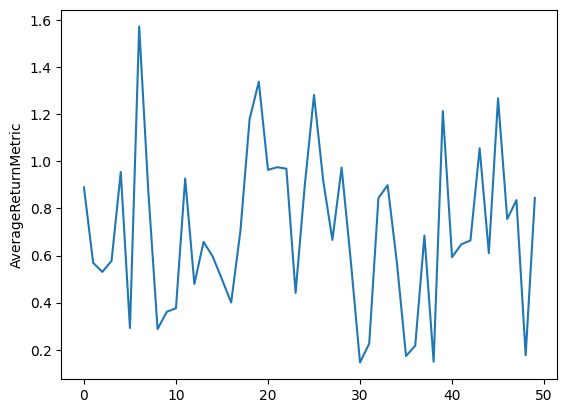

In [47]:
import matplotlib.pyplot as plt

plt.plot(metric_results['AverageReturnMetric'])
plt.ylabel('AverageReturnMetric')
plt.show()

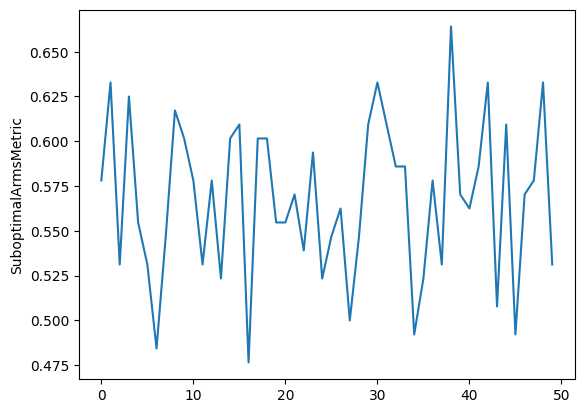

In [48]:
plt.plot(metric_results['SuboptimalArmsMetric'])
plt.ylabel('SuboptimalArmsMetric')
plt.show()

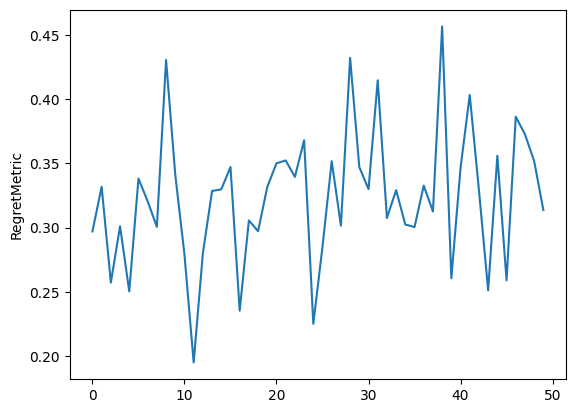

In [49]:
plt.plot(metric_results['RegretMetric'])
plt.ylabel('RegretMetric')
plt.show()

### TensorBoard

In [50]:
# %load_ext tensorboard
%reload_ext tensorboard

In [51]:
%tensorboard --logdir=$LOG_DIR

**Finished**